# 模組 5.2: 變數的冪轉換 (Power Transformations)

## 學習目標
- 理解為什麼需要將數據轉換為更接近常態（高斯）的分佈。
- 學習並實作對數轉換 (Log Transform)。
- 了解並實作更通用的 Box-Cox 和 Yeo-Johnson 轉換。
- 透過視覺化（如 Q-Q 圖）來評估轉換的效果。

## 導論：為何要改變分佈的形狀？

在上一個筆記本中，我們學習的縮放方法只改變特徵的 **尺度 (scale)**，而不改變其 **分佈形狀 (shape)**。然而，許多機器學習模型（特別是線性模型）的性能會因為特徵不服從常態分佈而下降。

**冪轉換 (Power Transformations)** 是一系列旨在 **改變變數分佈形狀** 的數學方法，它們可以：
- 穩定變異數。
- 處理偏態數據，使其更對稱、更像高斯分佈。
- 改善線性模型的效果。

您的指南中提到：「*處理偏態分佈（使其更接近常態分佈），穩定變異數，使關係線性化，減輕異常值的影響*」。這正是本筆記本的核心。

In [4]:
# 導入必要的函式庫
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
import scipy.stats as stats

import matplotlib.pyplot as plt
# 設定視覺化風格
# 'seaborn-v0_8-whitegrid' 提供了帶有白色網格的 seaborn 預設風格，更易於讀取
plt.style.use('seaborn-v0_8-whitegrid')
# 設置中文字體，以防圖表標題或標籤出現亂碼
# 請確保您的環境中已安裝 'Microsoft JhengHei' 或其他中文字型
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題
print("Matplotlib and Seaborn styles configured.")

# 忽略不必要的警告訊息
import warnings
warnings.filterwarnings('ignore')



Matplotlib and Seaborn styles configured.


## 1. 準備偏態資料

我們繼續使用 `insurance` 資料集，其中的 `charges` (醫療費用) 是一個典型的右偏（正偏）分佈。

成功載入 Insurance 資料集!


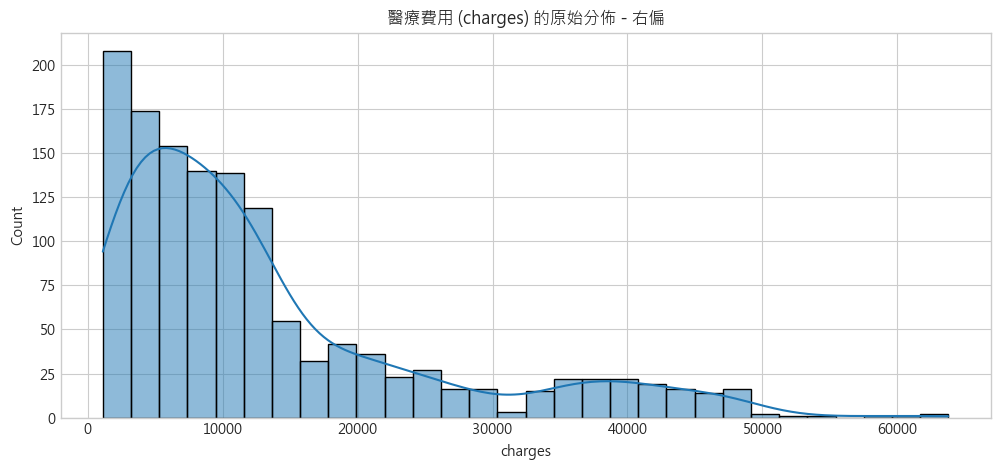

In [5]:
# 載入資料
path = r'..\..\..\..\datasets\raw\insurance\insurance.csv'
try:
    df = pd.read_csv(path)
    print("成功載入 Insurance 資料集!")
except FileNotFoundError:
    print(f"在 '{path}' 找不到 insurance.csv。")
    df = pd.DataFrame()

# 觀察 'charges' 的原始分佈
plt.figure(figsize=(12, 5))
sns.histplot(df['charges'], kde=True)
plt.title('醫療費用 (charges) 的原始分佈 - 右偏')
plt.show()



## 2. 對數轉換 (Log Transform)

- **原理**: 對每個數據點取自然對數 `log(x)`。
- **適用**: 處理 **右偏 (positively skewed)** 分佈。
- **限制**: **不能用於包含 0 或負值的數據**。如果數據中有 0，可以使用 `np.log1p(x)`，它計算的是 `log(1+x)`。

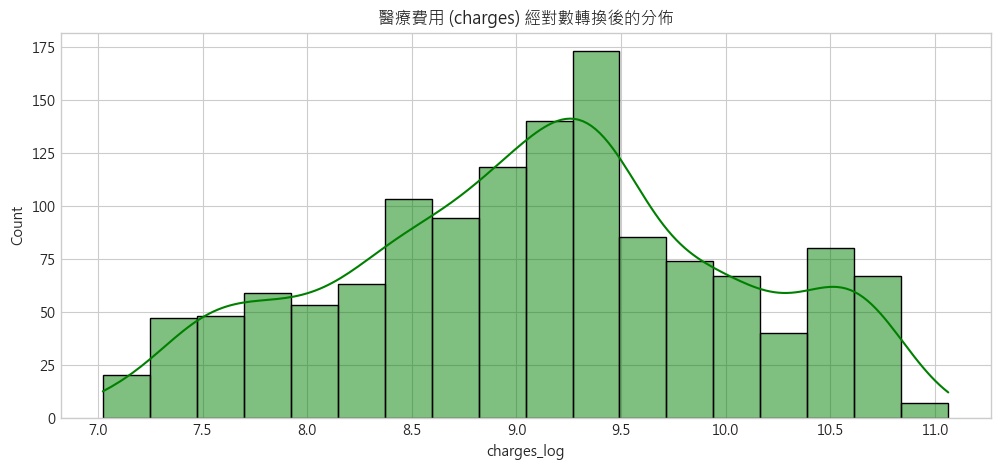

In [6]:
# 應用對數轉換
df['charges_log'] = np.log1p(df['charges'])

# 觀察轉換後的分佈
plt.figure(figsize=(12, 5))
sns.histplot(df['charges_log'], kde=True, color='green')
plt.title('醫療費用 (charges) 經對數轉換後的分佈')
plt.show()



**觀察**:
經過對數轉換後，原本高度右偏的分佈現在變得更對稱，更接近鐘形曲線（高斯分佈）。

## 3. 評估常態性：Q-Q 圖 (Quantile-Quantile Plot)

Q-Q 圖是一種視覺化工具，用於判斷樣本數據是否來自於某個理論分佈（在這裡是常態分佈）。
- **如果數據點緊密地落在紅色對角線上**，則表明樣本數據與常態分佈非常吻合。
- **如果數據點偏離對角線**，則表明樣本數據不服從常態分佈。

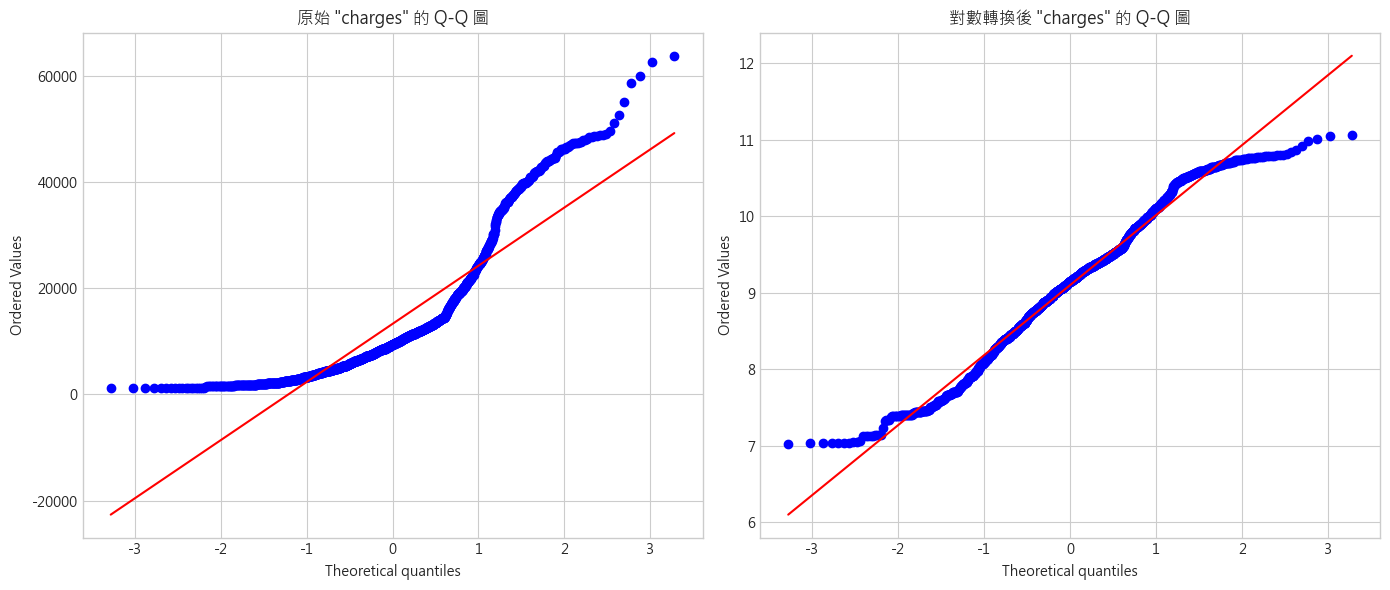

In [7]:
# 比較轉換前後的 Q-Q 圖
plt.figure(figsize=(14, 6))

# 原始數據的 Q-Q 圖
plt.subplot(1, 2, 1)
stats.probplot(df['charges'], dist="norm", plot=plt)
plt.title('原始 "charges" 的 Q-Q 圖')

# 對數轉換後數據的 Q-Q 圖
plt.subplot(1, 2, 2)
stats.probplot(df['charges_log'], dist="norm", plot=plt)
plt.title('對數轉換後 "charges" 的 Q-Q 圖')

plt.tight_layout()
plt.show()



**觀察**:
左圖中，原始數據的點在兩端嚴重偏離了紅線。而右圖中，對數轉換後的數據點幾乎完美地落在了紅線上，這有力地證明了對數轉換成功地使數據更接近常態分佈。

## 4. Box-Cox 與 Yeo-Johnson 轉換

`log(x)` 只是冪轉換家族中的一員。Scikit-learn 的 `PowerTransformer` 提供了兩種更通用、更自動化的方法，可以自動為數據找到最佳的冪次轉換參數 (λ)。

- **Box-Cox 轉換**:
  - 非常有效，但與對數轉換一樣，**要求所有數據都必須是正數**。

- **Yeo-Johnson 轉換**:
  - Box-Cox 轉換的推廣，**可以處理包含 0 和負值的數據**。

我們將 `PowerTransformer` 應用到 `bmi` 特徵上。

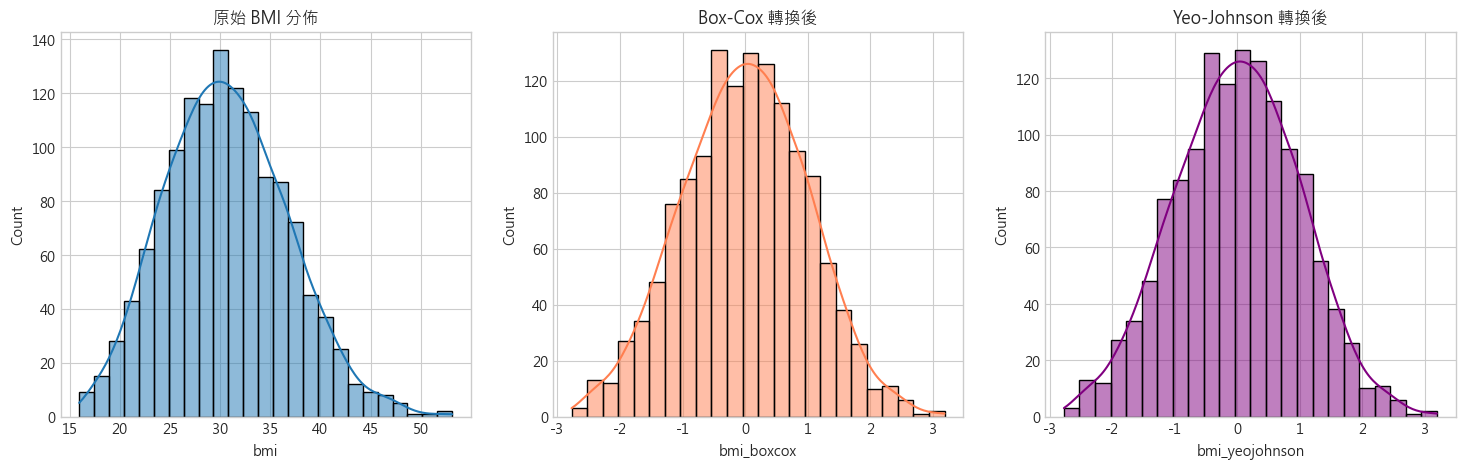

Box-Cox 找到的最佳 lambda: 0.4606
Yeo-Johnson 找到的最佳 lambda: 0.4432


In [8]:
# 準備 BMI 資料，並轉換為 2D 陣列
bmi = df[['bmi']].copy()

# 初始化轉換器
pt_boxcox = PowerTransformer(method='box-cox')
pt_yeojohnson = PowerTransformer(method='yeo-johnson')

# 進行轉換
bmi['bmi_boxcox'] = pt_boxcox.fit_transform(bmi[['bmi']])
bmi['bmi_yeojohnson'] = pt_yeojohnson.fit_transform(bmi[['bmi']])

# 視覺化比較
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(bmi['bmi'], kde=True, ax=axes[0]).set_title('原始 BMI 分佈')
sns.histplot(bmi['bmi_boxcox'], kde=True, ax=axes[1], color='coral').set_title('Box-Cox 轉換後')
sns.histplot(bmi['bmi_yeojohnson'], kde=True, ax=axes[2], color='purple').set_title('Yeo-Johnson 轉換後')
plt.show()

print(f"Box-Cox 找到的最佳 lambda: {pt_boxcox.lambdas_[0]:.4f}")
print(f"Yeo-Johnson 找到的最佳 lambda: {pt_yeojohnson.lambdas_[0]:.4f}")




## 總結

冪轉換是處理偏態數據、使其更符合模型假設的強大工具。

| 轉換方法 | 原理 | 優點 | 限制 |
| :--- | :--- | :--- | :--- |
| **對數轉換** | 取 `log(x)` 或 `log(1+x)` | 簡單、直觀、有效。 | **僅適用於正數** (或非負數)。 |
| **Box-Cox** | 自動尋找最佳 λ | 比對數轉換更通用、更優化。 | **僅適用於正數**。 |
| **Yeo-Johnson** | Box-Cox 的推廣 | **可以處理 0 和負數**，適用性最強。 | 數學上更複雜。 |

在應用這些轉換時，也必須遵循 **`fit on train, transform on train and test`** 的原則，以避免數據洩漏。